# DPLE: NH Ice Extent Check 
 - Check NH seasonal sea ice prediction
 - data I/O functions based on DPLE_ENSO_check.ipynb

In [28]:
import xarray as xr 
import numpy as np  
import cftime
import copy
import scipy.stats
from scipy import signal
import cartopy.crs as ccrs
import glob
import dask
import matplotlib.pyplot as plt
%matplotlib inline

## Create Dask Cluster

In [67]:
# Close out Dask Cluster and release workers:
# NOTE:  only run this cell to terminate Dask Cluster!
cluster.close()
client.close()

In [29]:
def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=1,
        memory='20GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=1:mem=10GB',
        project='NCGD0011',
        walltime='01:00:00',
        interface='ib0',)

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
    })
    client = Client(cluster)
    return cluster, client

In [30]:
cluster, client = get_ClusterClient()
cluster.scale(20) #adapt(minimum_jobs=0, maximum_jobs=24)

In [31]:
cluster

### Data I/O functions:
 - Run each of these cells, then proceed to Main Processing
 - Note that these functions are currently hard-wired to retrieve ocean monthly data

In [32]:
def file_dict(filetempl,mem,stmon):
    ''' returns a dictionary of filepaths keyed by initialization year, 
    for a given experiment, field, ensemble member, and initialization month '''
    memstr = '{0:03d}'.format(mem)
    monstr = '{0:02d}'.format(stmon)
    filepaths = {}
    
    filetemp = filetempl.replace('MM',monstr).replace('EEE',memstr)

    #find all the relevant files
    files = glob.glob(filetemp)
        
    for file in files:
        #isolate initialization year from the file name
        ystr = file.split('.pop.h.')[0]
        y0 = int(ystr[-11:-7])
        filepaths[y0]=file
        
    return filepaths

In [33]:
def nested_file_list_by_year(filetemplate,ens,field,firstyear,lastyear,stmon):
    ''' retrieve a nested list of files for these start years and ensemble members'''
    ens = np.array(ens)+1
    yrs = np.arange(firstyear,lastyear+1)
    files = []    # a list of lists, dim0=start_year, dim1=ens
    ix = np.zeros(yrs.shape)+1
    
    for yy,i in zip(yrs,range(len(yrs))):
        ffs = []  # a list of files for this yy
        file0 = ''
        first = True
        for ee in ens:
            filepaths = file_dict(filetemplate,ee,stmon)
            #append file if it is new
            if yy in filepaths.keys():
                file = filepaths[yy]
                if file != file0:
                    ffs.append(file)
                    file0 = file
        
        #append this ensemble member to files
        if ffs:  #only append if you found files
            files.append(ffs)
        else:
            ix[i] = 0
    return files,yrs[ix==1]

In [10]:
field = 'IFRAC'
datadir = '/glade/campaign/cesm/collections/CESM1-DPLE/ocn/proc/tseries/monthly/'
casename = 'b.e11.BDP.f09_g16.????-MM.EEE'
filetemplate = datadir+field+'/'+casename+'.pop.h.'+field+'.*.nc'
ens = range(40) 
leadtimes = range(24)
firstyear = 1960
lastyear  = 2018
stmon=11
files,yrs = nested_file_list_by_year(filetemplate,ens,field,firstyear,lastyear,stmon)

In [15]:
files[1][0:40]

['/glade/campaign/cesm/collections/CESM1-DPLE/ocn/proc/tseries/monthly/IFRAC/b.e11.BDP.f09_g16.1961-11.001.pop.h.IFRAC.196111-197112.nc',
 '/glade/campaign/cesm/collections/CESM1-DPLE/ocn/proc/tseries/monthly/IFRAC/b.e11.BDP.f09_g16.1961-11.002.pop.h.IFRAC.196111-197112.nc',
 '/glade/campaign/cesm/collections/CESM1-DPLE/ocn/proc/tseries/monthly/IFRAC/b.e11.BDP.f09_g16.1961-11.003.pop.h.IFRAC.196111-197112.nc',
 '/glade/campaign/cesm/collections/CESM1-DPLE/ocn/proc/tseries/monthly/IFRAC/b.e11.BDP.f09_g16.1961-11.004.pop.h.IFRAC.196111-197112.nc',
 '/glade/campaign/cesm/collections/CESM1-DPLE/ocn/proc/tseries/monthly/IFRAC/b.e11.BDP.f09_g16.1961-11.005.pop.h.IFRAC.196111-197112.nc',
 '/glade/campaign/cesm/collections/CESM1-DPLE/ocn/proc/tseries/monthly/IFRAC/b.e11.BDP.f09_g16.1961-11.006.pop.h.IFRAC.196111-197112.nc',
 '/glade/campaign/cesm/collections/CESM1-DPLE/ocn/proc/tseries/monthly/IFRAC/b.e11.BDP.f09_g16.1961-11.007.pop.h.IFRAC.196111-197112.nc',
 '/glade/campaign/cesm/collections

In [34]:
## NOTE
## Regulate dask array size using this proprocess function.
## Set appropriately based on analysis to come.
## E.g., currently set to extract only first 24 months of data
def preprocess(ds):
    return ds.isel(time=slice(0,24))
    #return ds

def open_members(in_obj):
    ffs = in_obj[0]  #unwrap the list
    field = in_obj[1]
    ens = in_obj[2]
    lm = in_obj[3]
    chunks = in_obj[4]
    
    d0 = xr.open_mfdataset(ffs,combine='nested',parallel=True,concat_dim='M',data_vars=[field],\
                           chunks=chunks,compat='override', coords='minimal', preprocess=preprocess)
    #added compat=override, coords=minimal here. Assumes that all hindcasts have same dims/coords. Seems a little dangerous
    #but REALLY speeds things up. And we know that the coords are the same for all of SMYLE anyway.

    # quick fix to adjust time vector for monthly data  
    nmonths = len(d0.time)
    yr0 = d0['time.year'][0].values
    d0['time'] =xr.cftime_range(str(yr0),periods=nmonths,freq='MS')
    
    # quick fix to compute seasonal means -- DOESN'T WORK!
    #month_length = d0.time.dt.days_in_month
    #d0 = ((d0 * month_length).resample(time='QS-JAN').sum() /
    #      month_length.resample(time='QS-JAN').sum())
    d0 = d0.assign_coords(M=("M",ens))
    d0 = d0.assign_coords(L=("time",lm))
    d0 = d0.swap_dims({'time': 'L'})
    d0 = d0.reset_coords(["time"])
    
    return d0

In [35]:
def get_monthly_data(filetemplate,ens,leads,field,firstyear,lastyear,stmon,chunks={}):
    ''' returns dask array containing the requested hindcast ensemble '''

    ds = xr.Dataset()    #instantiate Dataset
    lm = np.array(leads)+1
    files,yrs = nested_file_list_by_year(filetemplate,ens,field,firstyear,lastyear,stmon)
    ens = np.array(ens)+1
    
    # all members should have the same number of files, otherwise abort
    nfs = np.array([len(ffs) for ffs in files])
    if np.sum(nfs==nfs[0])==len(nfs):
        complete_set=True   # same number of files
    else:
        raise ValueError('ERROR: Incomplete set of files')
        
    if complete_set: #read all data using map/gather
        dsets = []
        in_obj = [[ffs, field, ens, lm, chunks] for ffs in files]
        dsets = client.map(open_members, in_obj)
        dsets = client.gather(dsets)
        tmp = xr.concat(dsets,dim='Y',data_vars=[field,'time','time_bound'], coords='minimal', compat='override')
        #potentially dangerous compat/coords option - xarray is NOT checking that the coordinates 
        #are the same across all files - pulling values of shared coords from the first file only
        #speeds up read-in time by ~1/3
        tmp = tmp.assign_coords(Y=("Y",yrs))

    ds[field] = tmp[field]
    ds['time'] = tmp['time']
    ds['time_bound'] = tmp['time_bound']
    ds['TAREA'] = tmp['TAREA']
    ds['UAREA'] = tmp['UAREA']

    return ds

# Main Processing

### Read in POP monthly field
- Chosen field is returned as a dask array with leading dimensions of Y (initialization year), M (ensemble member), and L (lead month)
- "time" and "time_bound" variables, which give prediction verification time, are also dimensioned with (Y,L) 

In [36]:
%%time
# DPLE data
# process all 40 ensemble members, lead months 1-24, all November start dates from 1954-2018:
field = 'IFRAC'
datadir = '/glade/campaign/cesm/collections/CESM1-DPLE/ocn/proc/tseries/monthly/'
casename = 'b.e11.BDP.f09_g16.????-MM.EEE'
filetemplate = datadir+field+'/'+casename+'.pop.h.'+field+'.*.nc'
ens = range(40) 
#leadtimes = range(122)
leadtimes = range(24)
firstyear = 1960
lastyear  = 2018
startmonth = 11
#chunks={'z_t':1,'nlat':80}
dple_ifrac = get_monthly_data(filetemplate,ens,leadtimes,field,firstyear,lastyear,startmonth)
dple_ifrac.nbytes/1e9 #GB

CPU times: user 13.3 s, sys: 3.02 s, total: 16.3 s
Wall time: 27.6 s


27.373766224

In [37]:
# take a look
dple_ifrac

<xarray.Dataset>
Dimensions:     (L: 24, M: 40, Y: 58, d2: 2, nlat: 384, nlon: 320)
Coordinates:
    TLAT        (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ULONG       (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ULAT        (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG       (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * M           (M) int64 1 2 3 4 5 6 7 8 9 10 ... 31 32 33 34 35 36 37 38 39 40
  * L           (L) int64 1 2 3 4 5 6 7 8 9 10 ... 15 16 17 18 19 20 21 22 23 24
  * Y           (Y) int64 1960 1961 1962 1963 1964 ... 2013 2014 2015 2016 2017
Dimensions without coordinates: d2, nlat, nlon
Data variables:
    IFRAC       (Y, M, L, nlat, nlon) float32 dask.array<chunksize=(1, 1, 24, 384, 320), meta=np.ndarray>
    time        (Y, L) object 1960-01-01 00:00:00 ... 2018-12-01 00:00:00
    time_bound  (Y, L, d2) object dask.array<chunksize=(1, 24, 2), meta=np.ndarray>
    TAREA       (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    UAREA       (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>

In [50]:
tmp = dple_ifrac.time_bound.load()
tmp.mean('d2').isel(Y=0).values

array([cftime.DatetimeNoLeap(1960, 11, 16, 12, 29, 59, 999998),
       cftime.DatetimeNoLeap(1960, 12, 16, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(1961, 1, 16, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(1961, 2, 15, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(1961, 3, 16, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(1961, 4, 16, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(1961, 5, 16, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(1961, 6, 16, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(1961, 7, 16, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(1961, 8, 16, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(1961, 9, 16, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(1961, 10, 16, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(1961, 11, 16, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(1961, 12, 16, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(1962, 1, 16, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(1962, 2, 15, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(1962, 3, 16, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(1962, 4, 16, 

In [38]:
# Full array can fit in distributed memory, so call persist
dple_ifrac = dple_ifrac.persist()

### Compute NH Ice Extent

In [39]:
def POP_regional_areawgt(ds,lon_lim,lat_lim):
    tarea = ds.TAREA/(100.**2)/(1000.**2)
    tarea['units'] = 'km^2'
    tlat = ds.TLAT
    tlon = xr.where(ds.TLONG>180.,ds.TLONG-360.,ds.TLONG)
    region = (tlat>=lat_lim[0]) & (tlat<=lat_lim[1]) & (tlon>=lon_lim[0]) & (tlon<=lon_lim[1])
    return xr.where(region,tarea.fillna(0),0)

In [40]:
POPg16_arctic_area = POP_regional_areawgt(dple_ifrac,[-180.,180.],[40.,82.])

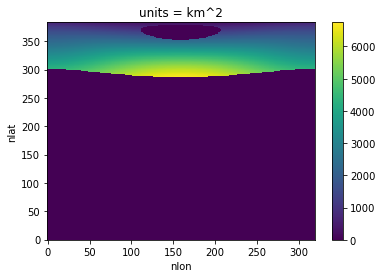

In [42]:
POPg16_arctic_area.plot()

In [43]:
POPg16_arctic_area

<xarray.DataArray (nlat: 384, nlon: 320)>
dask.array<where, shape=(384, 320), dtype=float64, chunksize=(384, 320), chunktype=numpy.ndarray>
Coordinates:
    TLAT     (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ULONG    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ULAT     (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    units    <U4 'km^2'
Dimensions without coordinates: nlat, nlon

- Here, perform actual computation, returning xarray

In [51]:
%%time
dple_nhice = (dple_ifrac.IFRAC.isel(L=slice(0,24))*POPg16_arctic_area).sum(("nlon", "nlat")).load()
dple_time_bound = dple_ifrac.time_bound.load()

CPU times: user 11.2 s, sys: 299 ms, total: 11.5 s
Wall time: 12.2 s


In [52]:
# Observed SIE (SSMI nsidc-0051)
ds_obs = xr.open_dataset('/glade/p/cgd/oce/people/yeager/obs/seaice/SSMI/nsidc-0051/nt_1979_01-2017_12.monthly.NH.nc',decode_times=False)
ds_obs['time'] = [cftime.DatetimeNoLeap(1979+year, 1+month, 15) for year in range(39) for month in range(12)]
region1 = (ds_obs.lat>=40) & (ds_obs.lat<=82)
areawgt1 = xr.where(region1, ds_obs.area.fillna(0),0)
obs_nhice = (ds_obs.ifrac*areawgt1).sum(("nlon", "nlat")).load()

In [53]:
dple_nhice

<xarray.DataArray (Y: 58, M: 40, L: 24)>
array([[[ 7043552.91841339,  9276092.14110428, 11018332.27305698, ...,
          3938204.25044935,  3545157.832559  ,  5573085.42725452],
        [ 7080759.47409416,  9242223.61771215, 10887509.28397575, ...,
          2832783.30173511,  2191000.11805988,  4497002.7811225 ],
        [ 7128541.60884373,  9363633.23041213, 10870646.87167549, ...,
          4194813.99890209,  3457200.1860016 ,  5443225.21391282],
        ...,
        [ 7060648.72377388,  9083949.93309884, 11022061.08605909, ...,
          4576323.33654859,  4221908.95858934,  5646441.38016423],
        [ 7061214.01461856,  9103584.68002592, 11120925.23703227, ...,
          4320043.42256378,  3863286.43394977,  5790913.66566433],
        [ 7055355.16573157,  9072135.04539141, 10800814.74959228, ...,
          3837626.00075732,  3284432.04317163,  4991014.38762854]],

       [[ 7085119.43700675,  9282744.63735136, 11029761.88713366, ...,
          4574508.97896411,  4045232.31882602,  6000035.24835764],
        [ 7044883.28811338,  9161959.50355563, 10790500.27991976, ...,
          4217926.64379404,  3600315.13253992,  5464273.06094987],
        [ 7108220.5903697 ,  9250560.12309708, 10822106.6418627 , ...,
          3611336.9951056 ,  3045459.73293108,  5247048.39704847],
...
        [ 4537422.62359902,  7704758.46361774,  9772698.84855455, ...,
          2443287.86080841,  1690361.85935349,  3151228.79648379],
        [ 4473650.65893007,  7643802.98097468,  9974433.26149502, ...,
          1555534.09608717,   782588.75199286,  2422441.78701054],
        [ 4540262.21099802,  7664215.93584096,  9706420.77678322, ...,
          1747422.47942816,  1197665.78617244,  2538703.12275553]],

       [[ 5300149.72261229,  8163840.75681914, 10442706.71586546, ...,
          2213946.08074529,  1447056.55635916,  3049956.96704178],
        [ 5305673.89912756,  8078592.67912912, 10214133.26124868, ...,
          1872899.05525123,  1146028.72840968,  3108824.98219716],
        [ 5326954.64265548,  8119562.92054383, 10094460.34104402, ...,
          2772808.45502758,  1965253.09059775,  3762007.48466813],
        ...,
        [ 5281104.73737998,  7996504.22011665, 10201135.87176379, ...,
          2005675.17536962,  1524477.45000629,  2948953.09144241],
        [ 5335460.32352439,  8140091.48289574, 10184842.846814  , ...,
          1909643.30169585,  1324100.81650862,  2846204.32183297],
        [ 5296134.11970717,  8201742.91919098, 10440082.93794798, ...,
          1278572.80383388,   849740.23271455,  1820870.5130626 ]]])
Coordinates:
  * M        (M) int64 1 2 3 4 5 6 7 8 9 10 11 ... 31 32 33 34 35 36 37 38 39 40
  * L        (L) int64 1 2 3 4 5 6 7 8 9 10 11 ... 15 16 17 18 19 20 21 22 23 24
  * Y        (Y) int64 1960 1961 1962 1963 1964 ... 2013 2014 2015 2016 2017
    units    <U4 'km^2'

In [56]:
obs_nhice.time.dt.days_in_month

<xarray.DataArray 'days_in_month' (time: 468)>
array([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31, 28, 31, 30, 31,
       30, 31, 31, 30, 31, 30, 31, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31,
       30, 31, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31, 28, 31,
       30, 31, 30, 31, 31, 30, 31, 30, 31, 31, 28, 31, 30, 31, 30, 31, 31,
       30, 31, 30, 31, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31,
       28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31, 28, 31, 30, 31, 30,
       31, 31, 30, 31, 30, 31, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30,
       31, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31, 28, 31, 30,
       31, 30, 31, 31, 30, 31, 30, 31, 31, 28, 31, 30, 31, 30, 31, 31, 30,
       31, 30, 31, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31, 28,
       31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31, 28, 31, 30, 31, 30, 31,
       31, 30, 31, 30, 31, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31,
       31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31, 28, 31, 30, 31,
       30, 31, 31, 30, 31, 30, 31, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31,
       30, 31, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31, 28, 31,
       30, 31, 30, 31, 31, 30, 31, 30, 31, 31, 28, 31, 30, 31, 30, 31, 31,
       30, 31, 30, 31, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31,
       28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31, 28, 31, 30, 31, 30,
       31, 31, 30, 31, 30, 31, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30,
       31, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31, 28, 31, 30,
       31, 30, 31, 31, 30, 31, 30, 31, 31, 28, 31, 30, 31, 30, 31, 31, 30,
       31, 30, 31, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31, 28,
       31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31, 28, 31, 30, 31, 30, 31,
       31, 30, 31, 30, 31, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31,
       31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31, 28, 31, 30, 31,
       30, 31, 31, 30, 31, 30, 31, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31,
       30, 31, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31, 28, 31,
       30, 31, 30, 31, 31, 30, 31, 30, 31])
Coordinates:
  * time     (time) object 1979-01-15 00:00:00 ... 2017-12-15 00:00:00

### Compute seasonal-average Time Series

In [57]:
def jfm_mean(ds):
    month_length = ds.time.dt.days_in_month
    result = ((ds * month_length).resample(time='QS-JAN').sum() /
          month_length.resample(time='QS-JAN').sum())
    return result.sel(time=result['time.month']==1)
def jas_mean(ds):
    month_length = ds.time.dt.days_in_month
    result = ((ds * month_length).resample(time='QS-JAN').sum() /
          month_length.resample(time='QS-JAN').sum())
    return result.sel(time=result['time.month']==7)

In [58]:
obs_nhice_jfm = jfm_mean(obs_nhice)
obs_nhice_jas = jas_mean(obs_nhice)

In [65]:
dple_time_bound.sel(L=[3,4,5]).isel(L=1).mean('d2')
#dple_time_bound.L

<xarray.DataArray 'time_bound' (Y: 58)>
array([cftime.DatetimeNoLeap(1961, 2, 15, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(1962, 2, 15, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(1963, 2, 15, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(1964, 2, 15, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(1965, 2, 15, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(1966, 2, 15, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(1967, 2, 15, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(1968, 2, 15, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(1969, 2, 15, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(1970, 2, 15, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(1971, 2, 15, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(1972, 2, 15, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(1973, 2, 15, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(1974, 2, 15, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(1975, 2, 15, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(1976, 2, 15, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(1977, 2, 15, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(1978, 2, 15, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(1979, 2, 15, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(1980, 2, 15, 0, 0, 0, 0),
...
       cftime.DatetimeNoLeap(1999, 2, 15, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2000, 2, 15, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2001, 2, 15, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2002, 2, 15, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2003, 2, 15, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2004, 2, 15, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2005, 2, 15, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2006, 2, 15, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2007, 2, 15, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2008, 2, 15, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2009, 2, 15, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2010, 2, 15, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2011, 2, 15, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2012, 2, 15, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2013, 2, 15, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2014, 2, 15, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2015, 2, 15, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2016, 2, 15, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2017, 2, 15, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2018, 2, 15, 0, 0, 0, 0)], dtype=object)
Coordinates:
    L        int64 4
  * Y        (Y) int64 1960 1961 1962 1963 1964 ... 2013 2014 2015 2016 2017

### Generate Time Series Plot

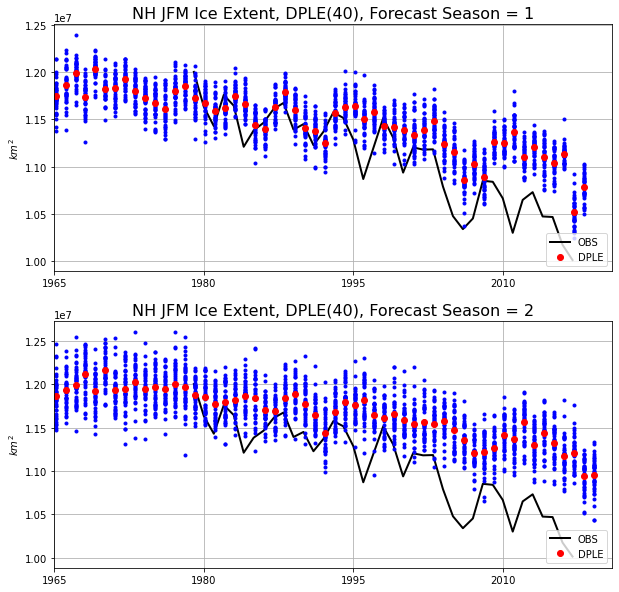

In [66]:
nlead = 2
fig = plt.figure(figsize=(10, nlead*5))
nrow = nlead
ncol = 1

xtickyears = [1960,1965,1975,1985,1995,2005,2015]
xticks = [cftime.num2date(0, 'days since '+str(i)+'-01-01 00:00:00', calendar='noleap') for i in xtickyears]
xmin = cftime.num2date(0, 'days since 1965-01-01 00:00:00', calendar='noleap')
xmax = cftime.num2date(0, 'days since 2021-01-01 00:00:00', calendar='noleap')

# JFM1
lrange = [3,4,5]
dpletime = dple_time_bound.sel(L=lrange).isel(L=1).mean('d2')
ax = fig.add_subplot(nrow,ncol,0*ncol+1)
ax.plot(obs_nhice_jfm.time, obs_nhice_jfm,linewidth=2,color='k',label='OBS')
ax.plot(dpletime,dple_nhice.sel(L=lrange).mean('L'),'.',color='b')
ax.plot(dpletime,dple_nhice.sel(L=lrange).mean('L').mean('M'),'o',color='r',label='DPLE')
ax.grid()
ax.set_title('NH JFM Ice Extent, DPLE(40), Forecast Season = {}'.format(1), fontdict={'size':16})
ax.set_ylabel(r'$km^{2}$')
#ax.set_ylim(23,30)
ax.set_xlim(xmin,xmax)
ax.legend(loc='lower right')

lrange = [15,16,17]    
dpletime = dple_time_bound.sel(L=lrange).isel(L=1).mean('d2')
ax = fig.add_subplot(nrow,ncol,1*ncol+1)
ax.plot(obs_nhice_jfm.time, obs_nhice_jfm,linewidth=2,color='k',label='OBS')
ax.plot(dpletime,dple_nhice.sel(L=lrange).mean('L'),'.',color='b')
ax.plot(dpletime,dple_nhice.sel(L=lrange).mean('L').mean('M'),'o',color='r',label='DPLE')
ax.grid()
ax.set_title('NH JFM Ice Extent, DPLE(40), Forecast Season = {}'.format(2), fontdict={'size':16})
ax.set_ylabel(r'$km^{2}$')
#ax.set_ylim(23,30)
ax.set_xlim(xmin,xmax)
ax.legend(loc='lower right')

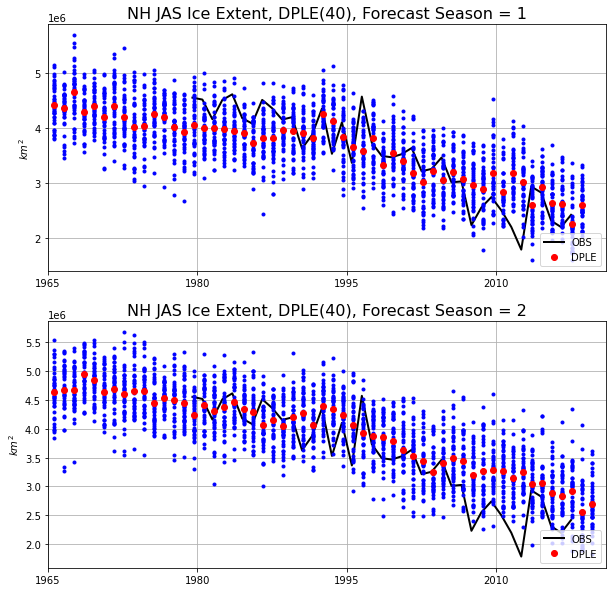

In [20]:
nlead = 2
fig = plt.figure(figsize=(10, nlead*5))
nrow = nlead
ncol = 1

xtickyears = [1960,1965,1975,1985,1995,2005,2015]
xticks = [cftime.num2date(0, 'days since '+str(i)+'-01-01 00:00:00', calendar='noleap') for i in xtickyears]
xmin = cftime.num2date(0, 'days since 1965-01-01 00:00:00', calendar='noleap')
xmax = cftime.num2date(0, 'days since 2021-01-01 00:00:00', calendar='noleap')

# JAS1
lrange = [9,10,11]
dpletime = dple_time_bound.sel(L=lrange).isel(L=1).mean('d2')
ax = fig.add_subplot(nrow,ncol,0*ncol+1)
ax.plot(obs_nhice_jas.time, obs_nhice_jas,linewidth=2,color='k',label='OBS')
ax.plot(dpletime,dple_nhice.sel(L=lrange).mean('L'),'.',color='b')
ax.plot(dpletime,dple_nhice.sel(L=lrange).mean('L').mean('M'),'o',color='r',label='DPLE')
ax.grid()
ax.set_title('NH JAS Ice Extent, DPLE(40), Forecast Season = {}'.format(1), fontdict={'size':16})
ax.set_ylabel(r'$km^{2}$')
#ax.set_ylim(23,30)
ax.set_xlim(xmin,xmax)
ax.legend(loc='lower right')

lrange = [21,22,23]
dpletime = dple_time_bound.sel(L=lrange).isel(L=1).mean('d2')
ax = fig.add_subplot(nrow,ncol,1*ncol+1)
ax.plot(obs_nhice_jas.time, obs_nhice_jas,linewidth=2,color='k',label='OBS')
ax.plot(dpletime,dple_nhice.sel(L=lrange).mean('L'),'.',color='b')
ax.plot(dpletime,dple_nhice.sel(L=lrange).mean('L').mean('M'),'o',color='r',label='DPLE')
ax.grid()
ax.set_title('NH JAS Ice Extent, DPLE(40), Forecast Season = {}'.format(2), fontdict={'size':16})
ax.set_ylabel(r'$km^{2}$')
#ax.set_ylim(23,30)
ax.set_xlim(xmin,xmax)
ax.legend(loc='lower right')